# 15. 문자를 읽을 수 있는 딥러닝
## 프로젝트 : 다양한 OCR모델 비교하기

### 기획 : 해외여행 시 다양한 간판에 대한 간판 인식 서비스
- 해외여행 시 각국 언어로 되어있는 간판에 대한 번역 및 간판 인식으로 해당 간판의 건물의 정보 제공.
- 간판을 인식하고 지도와 연동하여 해당 지점의 상세정보과 리뷰 등을 제공.

#### OCR 기술을 활용하여 다양한 간판을 인식한다.
(한국의 간판은 가독성 높은 정형화된 간판이 많아 다양하고 가독성이 떨어질 수도 있는 간판들도 인식하는지 확인하기 위해 해외의 거리 간판 이미지 사용 : 무료이미지 사이트)
- 크고 작은 글자의 간판 인식(먼 거리나, 매우 가까운 거리의 간판)
- 다양한 각도의 간판 인식(뒤섞인 배치)
- 필기체 등 다양한 폰트의 간판 인식(정형화되지 않은 간판)

등의 이미지 데이터들을 인식하는지 확인.

In [1]:
# 주요 라이브러리 버전 확인
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


### Step1. 검증용 데이터셋 준비
-----
OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.

In [2]:
import os

data_path  = os.getenv('HOME')+'/aiffel/ocr_python/test_image'
data_path

'/aiffel/aiffel/ocr_python/test_image'

In [3]:
# 입력 이미지 경로
image_list = os.listdir(data_path)
image_path = [data_path+'/'+name for name in image_list]
image_path = sorted(image_path)
image_path

['/aiffel/aiffel/ocr_python/test_image/test_image1.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_image2.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_image3.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_image4.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_image5.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_image6.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_image7.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_image8.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_image9.jpg']

### Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)
-----
위 두 가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다. 가능하다면 Google OCR API를 포함해 세 가지 모듈을 다 써보세요.

Step3. 테스트 결과 정리

### keras-ocr
- 이미지 속 문자를 읽는 End-to-End OCR.
- 검출 모델로는 네이버 데뷰 2018 영상에서 소개한 CRAFT(Character Region Awareness for Text Detection)를 사용하고, 인식 모델로는 앞에서 설명한 CRNN을 사용.

In [4]:
import matplotlib.pyplot as plt
import keras_ocr
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
# 테스트에 사용할 이미지 모으기, 기존 노드는 url이나 os.path.join(image_path, file) 으로 변경 필요. 

images = [keras_ocr.tools.read(path) for path in image_path]
prediction_groups = [pipeline.recognize({path}) for path in image_path]

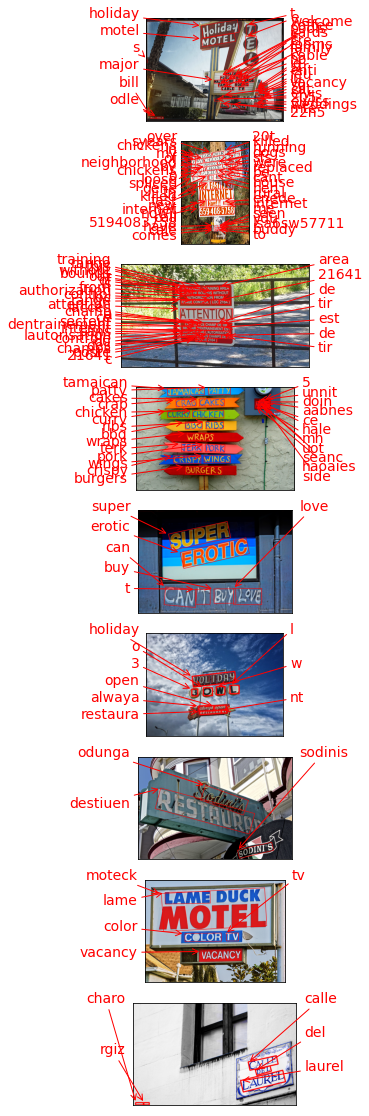

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract(테서랙트)
- 테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있음.
- OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저 해보자.

#### 테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [16]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test_image'
img_file_path = work_dir + '/test_image1.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0001.png
/aiffel/aiffel/ocr_python/test_image/0002.png
/aiffel/aiffel/ocr_python/test_image/0003.png
/aiffel/aiffel/ocr_python/test_image/0004.png
/aiffel/aiffel/ocr_python/test_image/0005.png
/aiffel/aiffel/ocr_python/test_image/0006.png
/aiffel/aiffel/ocr_python/test_image/0007.png
/aiffel/aiffel/ocr_python/test_image/0008.png
/aiffel/aiffel/ocr_python/test_image/0009.png
/aiffel/aiffel/ocr_python/test_image/0010.png
/aiffel/aiffel/ocr_python/test_image/0011.png
/aiffel/aiffel/ocr_python/test_image/0012.png


#### 테서랙트로 잘린 이미지에서 단어 인식
- 문자 인식을 해 볼 차례.
- 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 image_to_string()를 사용.
- 인식된 결과가 실제 이미지와 맞는지 확인.

In [17]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

가




~




-






：


|: ~


(가


|


81610


  !              : ,


Done


### Step3. 테스트 결과 정리
-----
모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

### Step4. 결과 분석과 결론 제시
-----
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다. 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다. 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

## 회고
keras-ocr에서부터 막혔다. '.ipynb_checkpoints' 에러가 뭔지 몰라서 구글에 검색해보았지만 해결하지 못했다. 저 파일로 인해 이미지를 불러오지 못해 다른 테스트들을 진행하지 못했다.
Tesseract와 Google OCR API라도 시도해보려고 했지만 Google OCR API는 계정관련 에러가 해결되지 못했고, Tesseract는 간판의 글자들을 인식하지 못했다.
각 모델의 출력 형태에 따라 결과를 비교해 보고 싶었지만 간판 이미지 인식부터 막혀서 이번 프로젝트는 실패.. 가볍게 생각하고 쉽겠다고 만만하게 봤는데 이런 반전의 결과를 선사하다니..